In [8]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import random
import csv
from datetime import datetime

from langchain.schema.runnable import RunnableSequence

In [9]:
# Do imports for squad_scoring and prompts
from pathlib import Path

utils_folder = Path("..")
sys.path.append(str(utils_folder))

utils_folder = Path("../src/deh")
sys.path.append(str(utils_folder))

utils_folder = Path(".")
sys.path.append(str(utils_folder))

import squad_scoring
import deh_prompts
import deh_vector_store
import deh_squad_data
import deh_hyde
from deh_llm import get_llm

##### Set Global variables

In [10]:
# # Folders for storing data and the results
DATA_ROOT = "../../../deh_data_results/data"         # Set to your own data folder
RESULTS_ROOT = "../../../deh_data_results/results"   # Set to your own results folder
HYDE_BASED_CONTEXTS_ROOT = F"{DATA_ROOT}/hyde_based_contexts"   # Set to your own results folder

# SQuAD dataset
data_file = f"{DATA_ROOT}/dev-v2.0.json"
dataset = squad_scoring.load_dataset(data_file)

# # Vector Store Parameters
VECTOR_STORE_TOP_K = 5
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 100
DEFAULT_CHROMA_PREFIX = "deh_rag"
#DEFAULT_CHROMA_COLLECTION = "per_article"
DEFAULT_CHROMA_COLLECTION = "per_article"
CHUNK_SQUAD_DATASET = False        # Set to True to vectorize the squad dataset. If False, 
                                   # then the documents and their embeddings should already
                                   # exist in the vector store.

# # CONTEXT Creation Parameters
REFRESH_QUESTION_CONTEXTS = False   # Set to True to create question contexts from the vector store; 
                                    # if False, the question contexts are loaded from a csv file.
REFRESH_HYDE_CONTEXTS = True       # Set to True to create hyde contexts; if False,
#                                   # the hyde contexts are loaded from a csv file.                                    

READ_QAS_FROM_FILE = True

# # Bootstrap Parameters
SAMPLE_SIZE = 100
BOOTSTRAPS_N = 1000
# #TODO check if this code is ok for setting the seed
# # SEED = 42
# # set_seed = random.seed(SEED)

# PERSIST_ANSWER_SAMPLES = False   # Set to True to persist the llm answers for each sample, for each experiment


##### Load the SQuAD Dataset

In [42]:
csv_file_path = f"{DATA_ROOT}/qas_with_contexts.csv"

# load the squad data to initialize articles, contexts, qas_with_duplicates, qas, unique_questions
# note that qas may be overwritten in the next statement, if READ_QAS_FROM_FILE is True

print(f"Loading squad data...")

column_names = ["title", "squad_context", "qid", "question", "is_impossible", "answer"]
squad_raw = pd.read_csv(f"{DATA_ROOT}/squad_raw.csv", names=column_names)
df_squad_raw = pd.DataFrame(squad_raw)
df_squad_raw.head(5)

df_titles = pd.DataFrame(df_squad_raw['title'].unique(), columns=["title"])
df_contexts = pd.DataFrame(df_squad_raw['squad_context'].unique(), columns=["squad_context"])
print(f"Number of unique contexts: {len(df_contexts)}")

df_qas = df_squad_raw[['qid', 'question', 'squad_context']].drop_duplicates()
df_qas.head(5)
print(f"Number of unique questions: {len(df_qas)}")

# articles, contexts, qas_raw, qas, unique_questions = deh_squad_data.load_squad_data()

# squad_raw = pd.read_csv(f"{DATA_ROOT}/squad_raw.csv")


# if READ_QAS_FROM_FILE: 
#     print(f"Reading qas and contexts from a csv file...")
    
#     # Read the qas dataset (including contexts) from a CSV file
#     qas = []

#     with open(csv_file_path, mode='r') as file:
#         csv_reader = csv.reader(file)
        
#         for i, row in enumerate(csv_reader):
#             if i == 0:
#                 continue
#             qas.append({"title": row[0], "context": row[1], "qid": row[2], "question": row[3], "is_impossible": row[4], 
#                         "answer": row[5], "hyde_article": row[6], "hyde_based_context": row[7], "question_context": row[8]})
            
            

Loading squad data...
Number of unique contexts: 1205
Number of unique questions: 11859


In [43]:
df_squad_raw.head(5)

,title,squad_context,qid,question,is_impossible,answer
0,title,context,qid,question,is_impossible,answer
1,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
2,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
3,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
4,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France


In [49]:
# Define the column names
#column_names = ['Name', 'Age', 'Country']

qas_with_contexts_csv_file_path = f"{DATA_ROOT}/qas_with_contexts.csv"

# Read the CSV file and assign the column names
df_qas_with_contexts = pd.read_csv(qas_with_contexts_csv_file_path) #, names=column_names)

df_qas_with_contexts.head(5)

df_temp = df_qas_with_contexts[["title", "context", "qid", "question", "is_impossible", "hyde_article", "hyde_based_context", "question_context"]]
df_temp.head(5)
df_temp = def_temp[['qid', 'question', 'squad_context']].drop_duplicates()
len(df_temp)


16209

##### Intialize the Vector Store (Chroma; Milvus not yet included)

In [5]:
if CHUNK_SQUAD_DATASET:    
    deh_vector_store.chunk_squad_dataset(contexts, dataset, CHUNK_SIZE, CHUNK_OVERLAP)
else:
    print("Chunking not foreseen. Skipping chunking.")

Chunking not foreseen. Skipping chunking.


In [6]:
# Intiialize the Chroma vector store
vector_store = deh_vector_store.get_vector_store(DEFAULT_CHROMA_PREFIX, DEFAULT_CHROMA_COLLECTION)

##### Get hyde-based contexts

Always get hyde-based contexts that already exist and these to the qas dataset

In [7]:
if not READ_QAS_FROM_FILE:
    hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
    hyde_based_contexts, questions_already_processed = deh_hyde.get_hyde_based_contexts(hyde_based_context_path)
    print(f"Number of questions with hyde-based context: {len(questions_already_processed)}")

In [8]:
if not READ_QAS_FROM_FILE:
    # Now add the hyde-based contexts to the qas dataset
    def get_hyde_based_info_from_qid(qid):
        for hbc in hyde_based_contexts:
            if hbc["qid"] == qid:
                return (hbc["hyde_article"], hbc["hyde_based_context"])
        return ("", "")

    for qa in qas:
        qid = qa["qid"]
        hyde_article, hyde_based_context = get_hyde_based_info_from_qid(qid)
        qa["hyde_article"] = hyde_article
        qa["hyde_based_context"] = hyde_based_context


##### Normal (i.e. not hyde-based) Question Contexts

Questions:

- if configured, either: generate normal question contexts and then persist
- or: read the question contexts from a .csv file


In [9]:
def persist_question_contexts(qas, csv_file_path):

    # Write the the qas dataset including the question contexts to a CSV file
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
        fieldnames = ["title", "context", "qid", "question", "is_impossible",
                      "answer", "hyde_article", "hyde_based_context", "question_context"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()   # Write the header row
        writer.writerows(qas)  # Write the data rows

    print(f"Data successfully written to {csv_file_path}")


In [10]:
# Refresh question contexts (normal contexts and hyde-based contexts)
if REFRESH_QUESTION_CONTEXTS or REFRESH_HYDE_CONTEXTS:
    print(f"Generating question contexts for the dataset and persisting these in a csv file...")

    for i, qa in enumerate(qas):
        if i %100 == 0:
            print(f"Processing question {i}...")

        if REFRESH_QUESTION_CONTEXTS:
            question = qa["question"]
            
            top_docs = vector_store.similarity_search(
                query = question,
                k = VECTOR_STORE_TOP_K,
            )
            qa["question_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

        if REFRESH_HYDE_CONTEXTS:
            hyde_article = qa["hyde_article"]
            if len(hyde_article) > 0:
                #print(f"hyde_article: {hyde_article}")
                top_docs = vector_store.similarity_search(
                    query = hyde_article,
                    k = VECTOR_STORE_TOP_K,
                )

                qa["hyde_based_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

    persist_question_contexts(qas, csv_file_path)



Generating question contexts for the dataset and persisting these in a csv file...
Processing question 0...
Processing question 100...
Processing question 200...
Processing question 300...
Processing question 400...
Processing question 500...
Processing question 600...
Processing question 700...
Processing question 800...
Processing question 900...
Processing question 1000...
Processing question 1100...
Processing question 1200...
Processing question 1300...
Processing question 1400...
Processing question 1500...
Processing question 1600...
Processing question 1700...
Processing question 1800...
Processing question 1900...
Processing question 2000...
Processing question 2100...
Processing question 2200...
Processing question 2300...
Processing question 2400...
Processing question 2500...
Processing question 2600...
Processing question 2700...
Processing question 2800...
Processing question 2900...
Processing question 3000...
Processing question 3100...
Processing question 3200...
Proce

##### Define functions that are needed for experiments

In [11]:
# Create the runnable chain
def get_runnable_chain(current_query_prompt, llm):
    runnable_chain = RunnableSequence(current_query_prompt | llm)
    return runnable_chain

In [12]:
# Get the Hyde context for a question
# Could be made much more efficient by creating a dictionary of hyde contexts
def get_hyde_context(question):
    for qa in qas:
        if qa["question"] == question:
            return qa["hyde_based_context"]
    return None

In [13]:
# generate the LLM answers, using a runnable chain and the sample of questions provided
def generate_llm_answers(runnable_chain, qas_sample, hyde=False):
    
    preds = {}

    sample_size = len(qas_sample)
    print(f"sample_size: {sample_size}")

    for i, qa in enumerate(qas_sample):

        question = qa["question"]
        if hyde:
            #context = qa["hyde_context"]
            context = get_hyde_context(question)
        else:
            context = qa["vector_store_context"]
            
        # print(f"question --> {question}")
        # print(context)
        response = runnable_chain.invoke({"context": context, "question": question})
                
        qid = squad_scoring.get_qid_from_question(question, dataset)
        
        if response.content.upper() == "DONT KNOW":
            llm_answer = ""
        else:
            llm_answer = response.content

        preds[qid] = llm_answer
        qas_sample[i]["llm_answer"] = llm_answer

    return preds


In [14]:
#%%capture

# Get the metrics for a set of predictions (preds) that have been generated in a run
def get_squad_metrics(dataset, preds, verbose=False):
    squad_metrics = squad_scoring.calc_squad_metrics(dataset, preds);
    return squad_metrics["precision"], squad_metrics["recall"], squad_metrics["f1"]


In [15]:
# Calculate the mean and confidence interval for a list of scores
# TODO: Check if this is calculation is correct !!
def calculate_mean_confidence_interval(scores_l):

    # Calculate mean
    mean = np.mean(scores_l)

    # Calculate 95% confidence interval
    sample_std_dev = np.std(scores_l, ddof=1)
    margin_of_error = 1.96 * sample_std_dev
    ci = (max(mean - margin_of_error, 0), min(mean + margin_of_error, 100))
    # if ci[0] < 0:
    #     ci = (0, ci[1])
    # if ci[1] > 100:
    #     ci = (ci[0], 100)

    return mean, ci

In [16]:
# Generate a histogram for a list of scores and persist it
def generate_histogram(scores_l, mean, ci, results_folder_name, experiment_name):

    plt.clf
    plt.hist(scores_l, bins=30, density=False, edgecolor='black', alpha=0.6, color = 'lightblue' ) # color='aquamarine')
    plt.xlim(0, 100)
    # # Configure major and minor ticks
    # major_tick_locator = MultipleLocator(10)  # Major ticks every 10
    # minor_tick_locator = MultipleLocator(5)   # Minor ticks every 5
    # ax = plt.gca()  # Get the current axis
    # ax.xaxis.set_major_locator(major_tick_locator)
    # ax.xaxis.set_minor_locator(minor_tick_locator)

    plt.title(f"F1-Scores for {experiment_name} - (Bootstraps: {BOOTSTRAPS_N} - Sample Size: {SAMPLE_SIZE})", fontsize=10)
    plt.xlabel("F1-Score")
    plt.ylabel("Frequency")

    # Add a vertical line for the mean
    max_len = 6
    mean_label = f"{mean: .2f}".rjust(max_len)
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2, label=f'Mean F1:          {mean_label}')

    # Add vertical lines for the 95% confidence interval
    #lower = f"{str(round(ci[0], 2))}"    .rjust(5)
    lower = f"{ci[0]: .2f}".rjust(max_len)
    upper = f"{ci[1]: .2f}".rjust(max_len)
    plt.axvline(ci[0], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Lower:  {lower}")
    plt.axvline(ci[1], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Upper:  {upper}")

    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_locator(MultipleLocator(10))  # Major ticks every 10 units
    ax.xaxis.set_minor_locator(MultipleLocator(5))   # Minor ticks every 5 units
    ax.yaxis.set_major_locator(MultipleLocator(10))   # Example: Major ticks every 5 units on the y-axis

    # Customize grid for major and minor ticks
    ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5)

    # # Configure major ticks
    # ax = plt.gca()  # Get current axis
    # ax.xaxis.set_major_locator(MultipleLocator(10))  # Major ticks every 10 units
    # #ax.yaxis.set_major_locator(MultipleLocator(5))   # Major ticks every 5 units (example)
    # ax.xaxis.set_minor_locator(MultipleLocator(5))  # Major ticks every 10 units

    # # Optionally customize the grid (if you want grid lines on major ticks)
    # ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)

    plt.legend(prop={'family': 'monospace', 'size': 10})
    plt.legend(loc='upper right', fontsize=10)

    plt.savefig(os.path.join(results_folder_name, f"{experiment_name}_{BOOTSTRAPS_N}_{SAMPLE_SIZE}"))
    return plt

In [17]:
my_str1 = "0.41"
print(f"my_str1: *{my_str1.rjust(4)}*")

my_str1: *0.41*


##### Define functions for Bootstrapping

In [18]:
# Get the current timestamp and format the start timestamp as a string
def get_timestamp_as_string():
    start_timestamp = datetime.now()
    start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')
    return start_timestamp_str

In [19]:
def calculate_scores(qas, query_prompt_idx, experiment_name, context_needed=False, suppress_answers=False):

    # Create the chain
    current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]
    print(f"current_query_prompt = {current_query_prompt.template}\n")
    llm = get_llm(current_query_prompt)
    runnable_chain = get_runnable_chain(current_query_prompt, llm)

    # Generate the LLM answers for all questions and calculate per-answer metrics 
    # add each answer to the all_preds
    preds = {}
    all_preds= {}
    for i, qa in enumerate(qas):

        if i % 10 == 0:
            print(f"Processing question {i}...")

        qid = qa["qid"]
        question = qa["question"]

        if context_needed:
            if experiment_name == "BASIC_RAG_HYDE":
                context = qa["hyde_based_context"]
            elif experiment_name == "FULL_RAG":
                context = qa["question_context"] + "\n\n" + qa["hyde_based_context"]
            else:
                context = qa["question_context"]
            response = runnable_chain.invoke({"question": question, "context": context})
        else:
            response = runnable_chain.invoke({"question": question})

        llm_answer = response.content

        if llm_answer.upper() == "DONT KNOW":
            if suppress_answers:
                continue
            else:
                llm_answer = ""

        preds[qid] = llm_answer
        all_preds[qid] = llm_answer

        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]

        preds = {}
        qa[f"{experiment_name.lower()}_llm_answer"] = llm_answer
        qa[f"{experiment_name.lower()}_f1"] = f1
        qa[f"{experiment_name.lower()}_precision"] = precision
        qa[f"{experiment_name.lower()}_recall"] = recall

    return all_preds
        

In [20]:
def persist_results(results_folder_name, experiment_name, df):

    # if not os.path.exists(results_folder_name):
    #     os.makedirs(results_folder_name)
    # print(f"results_folder_name: {results_folder_name}")
    df = pd.DataFrame(qas)
    df.to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_scores.csv", header=True, index=False)

In [21]:
def clip_scores(scores_l, clip_perc):
    scores_sorted_l = sorted(scores_l)

    clip_cnt = int(len(scores_sorted_l) * clip_perc / 100)
    print(f"clip_cnt: {clip_cnt}")

    # Now clip both ends by clip_perc percent
    clipped_scores_l = scores_sorted_l[clip_cnt:-clip_cnt] if clip_cnt > 0 else scores_sorted_l
    return clipped_scores_l


In [22]:
# my_list = list(range(200))
# print(f"len(my_list): {len(my_list)}")
# my_list_clipped = clip_scores(my_list, 2.5)
# print(f"len(my_list_clipped): {len(my_list_clipped)}")

In [23]:
def do_bootstrapping(scores_l, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):

    mu_hats = []
    n = len(scores_l)
    scores_l = clip_scores(scores_l, 2.5)
    #print(f"scores_l: {scores_l}")
    for i in range(bootstraps_n):
        if i % 100 == 0:
            print(f"Processing sample {i}...")
        bootstrap_sample = random.choices(scores_l, k=n) # sample with replacement
        mu_hat = np.mean(bootstrap_sample)
        mu_hats.append(mu_hat)

    bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
    #print(f"mu_hats: {mu_hats}")
    plt = generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name)
    plt.show();
    #plt.clf();

In [24]:
# def do_bootstrapping_all_preds(all_preds, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):

#     mu_hats = []
#     n = len(all_preds)
#     all_preds_list = [{k: v} for k, v in all_preds.items()]

#     for i in range(bootstraps_n):
#         if i % 100 == 0:
#             print(f"Processing sample {i}...")

#         # TODO: There is likely a much more efficient way to implement this
#         sample_idxs = random.choices(range(n), k=n)
#         bootstrap_sample_preds = {}
#         for i in sample_idxs:
#             pred = all_preds_list[i]
#             bootstrap_sample_preds.update(pred)
#             #print(f"pred: {pred}")
#             #my_sample_preds[] = pred

#         #bootstrap_sample_preds = random.choices(all_preds, k=n) # sample with replacement

#         scores = squad_scoring.calc_squad_metrics(dataset, bootstrap_sample_preds)
#         #mu_hat = np.mean(bootstrap_sample)
#         mu_hats.append(scores["f1"])

#     bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
#     #print(f"mu_hats: {mu_hats}")
#     plt = generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name + "_all_preds")
#     plt.show()
#     plt.clf()

In [25]:
# my_preds=  {'5726a7ecf1498d1400e8e657': 'The Treaty of Rome, Article 81.', '5ad26a5fd7d075001a429318': 'Work or sliding motion, depending on force applied.', '5ad3bb12604f3c001a3feeba': 'Unified command structure to focus Prussian war effort.', '56de49a8cffd8e1900b4b7a9': 'The company sold its rights to a new owner.', '5ad565575b96ef001a10adb3': 'A solution that combines both problems.', '573312fcd058e614000b56e6': "Monocle's Quality of Life Survey, 2021.", '5729f2646aef051400155132': 'Approximately 200,000 metric tons of live plants.', '5a38d93da4b263001a8c195b': '1940, marking a significant shift in global oil dominance.', '5726701add62a815002e84c9': 'At the base of a mountain or fault block.', '5729fd111d046914007796a9': 'RNA interference (RNAi) technology.', '57287ccb2ca10214002da3da': 'The Mongol Empire, under Kublai Khan.', '5ad502385b96ef001a10a958': 'The history of the Polish Winged Hussars.', '5ad04de377cf76001a686fa6': 'The state of California, USA.', '57300888b2c2fd1400568778': 'Colonia Nova Roma.', '5727e6cbff5b5019007d97f2': 'They dispute criticism, citing methodology and data reliability concerns.', '572ff56304bcaa1900d76f2e': 'The water flows into the Oude Rijn river.', '572fb059947a6a140053cb84': 'The Painted Hall in Westminster Palace.', '5728fc2eaf94a219006a9ecb': 'Intercourse with semen.', '570611c475f01819005e793d': 'Port of New York/New Jersey.', '5ad0278077cf76001a686be6': 'The boat skylights are located in the Grand Lobby.', '5ad5316b5b96ef001a10ab74': 'Tasks requiring human intuition, creativity, or moral judgment.', '5ad40419604f3c001a3ffdb8': 'The Philippines, Indonesia, Malaysia, and Japan are examples.', '5a25e4a2ef59cd001a623d0b': 'The time element in construction is called "time bar".', '5a25d529ef59cd001a623cf0': 'When a builder takes on excessive risk themselves.', '5727e8424b864d1900163fc0': 'About 160 million, or roughly half the population.', '5a638bf768151a001a922365': 'Around 25% globally, according to recent data.', '5a3e44ea378766001a002534': 'Famous historical figures, such as Galileo and Copernicus.', '57302bd0b2c2fd14005689dd': 'The Islamic State proclaimed itself as a caliphate.', '571a53d410f8ca1400304fe5': 'Crust, composed of minerals like olivine and pyroxene.', '5acfe89777cf76001a686411': 'Egyptian secular democracies, such as Tunisia.'}
# my_list = [{k: v} for k, v in my_preds.items()]
# my_n = len(my_list)
# print(f"my_n: {my_n}")

# my_sample = random.choices(range(my_n), k=my_n)
# print(f"my_sample: {my_sample}")
# print(f"my_list: {my_list}")
# my_sample_preds = {}
# for i in my_sample:
#     pred = my_list[i]
#     my_sample_preds.update(pred)
#     #print(f"pred: {pred}")
#     #my_sample_preds[]
# print(f"my_sample_preds: {my_sample_preds}")
# print(f"len(my_sample_preds): {len(my_sample_preds)}")

In [26]:
def create_results_folder(experiment_name):
    start_timestamp_str = get_timestamp_as_string()
    results_folder_name = f"{RESULTS_ROOT}/{experiment_name}/results_{start_timestamp_str}"
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name, exist_ok=True)
    return results_folder_name

In [27]:
def conduct_experiment(qas, experiment_name, query_prompt_idx, context_needed=False, suppress_answers=False):

    print(f"============= Creating results folder for {experiment_name} =============")
    results_folder_name = create_results_folder(experiment_name)
    
    print(f"============= Calculating scores for {experiment_name} =============")
    print(f"SAMPLE_SIZE: {SAMPLE_SIZE}")
    all_preds = calculate_scores(qas, query_prompt_idx, experiment_name, context_needed, suppress_answers)
    print(f"all_preds: {all_preds}")

    print(f"============= Persisting results for {experiment_name} =============")
    df = pd.DataFrame(qas)
    persist_results(results_folder_name, experiment_name, df)

    print(f"\n============= Bootstrapping for {experiment_name} =============")
    print(f"BOOTSTRAPS_N: {BOOTSTRAPS_N}")
    do_bootstrapping(df[f"{experiment_name.lower()}_f1"].dropna().tolist(), results_folder_name, experiment_name, BOOTSTRAPS_N)
    # print(f"\nBOOTSTRAPS_N for all_preds: {BOOTSTRAPS_N}")
    # do_bootstrapping_all_preds(all_preds, results_folder_name, experiment_name, BOOTSTRAPS_N)

##### Creating a sample from qas for bootstrapping and bootstrapping with Hyde (will be used for all experiments)

In [28]:
# Getting qid, question, question_context
qas_for_bootstrapping = [{"qid": qa["qid"], "question": qa["question"], "question_context": qa["question_context"]} for qa in qas]
# Removing duplicates
qas_for_bootstrapping = list({frozenset(item.items()): item for item in qas_for_bootstrapping}.values())
# Taking a sample of size SAMPLE_SIZE
qas_for_bootstrapping = random.sample(qas_for_bootstrapping, SAMPLE_SIZE)
len(qas_for_bootstrapping)

qas_for_hyde_bootstrapping = [{"qid": qa["qid"], "question": qa["question"], "hyde_based_context": qa["hyde_based_context"], "question_context": qa["question_context"]} for qa in qas if len(qa["hyde_based_context"]) > 0]
# Removing duplicates
qas_for_hyde_bootstrapping = list({frozenset(item.items()): item for item in qas_for_hyde_bootstrapping}.values())
# Taking a sample of size SAMPLE_SIZE for hyde experiment
qas_for_hyde_bootstrapping = random.sample(qas_for_hyde_bootstrapping, SAMPLE_SIZE)


##### Calculate Resulst for NO_RAG

============= Creating results folder for NO_RAG =============
============= Calculating scores for NO_RAG =============
SAMPLE_SIZE: 100
current_query_prompt = 
    You are an assistant for question-answering tasks.
    Use ten words maximum and keep the answer concise.

    Question: {question}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
all_preds: {'572fe9b3947a6a140053cde2': 'The Rhine receives 360 cubic meters per second.', '57274e145951b619008f87e7': 'Publicly funded institutions, also known as public schools.', '5a38b468a4b263001a8c18b4': "It's referred to as Takfiri.", '572ff890a23a5019007fcbcf': 'The North Sea flooded into the delta.', '570d26efb3d812140066d48f': 'The Victorian Legislative Council has a bicameral representative system.', '570d4329

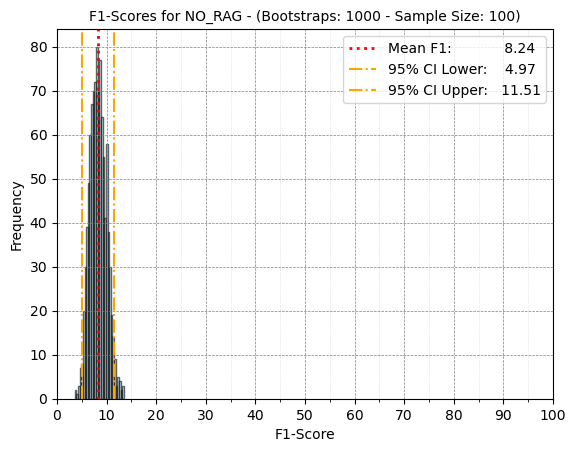

In [29]:
conduct_experiment(qas_for_bootstrapping, "NO_RAG", 0, context_needed=False)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Sample data
x = range(0, 101)
y = [value**0.5 for value in x]

# Create the plot
plt.plot(x, y)

# Set the range for the x-axis
plt.xlim(0, 100)

# Configure major and minor ticks
major_tick_locator = MultipleLocator(10)  # Major ticks every 10
minor_tick_locator = MultipleLocator(5)   # Minor ticks every 5

# Apply tick locators to the x-axis
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(major_tick_locator)
ax.xaxis.set_minor_locator(minor_tick_locator)

# Optionally, customize the grid
ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Plot with Major and Minor Ticks")

# Show the plot
plt.show()

##### Calculating scores for BASIC_RAG

============= Creating results folder for BASIC_RAG =============
============= Calculating scores for BASIC_RAG =============
SAMPLE_SIZE: 100
current_query_prompt = 
    You are an assistant for question-answering tasks.
    Please only use the following pieces of retrieved context to answer the question.
    Use ten words maximum and keep the answer concise.

    Question: {question}
    Context: {context}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
all_preds: {'57094b4f9928a814004714fa': "British Midland's low-cost subsidiary, Sky Travel.", '5a668d25f038b7001ab0bfb0': 'DECnet Phase I became a network protocol.', '57286ead2ca10214002da34a': 'Temur ruled as Timurid Emperor from 1370-1405.', '572908c13f37b31900477fbf': 'The adaptive branch of the immune s

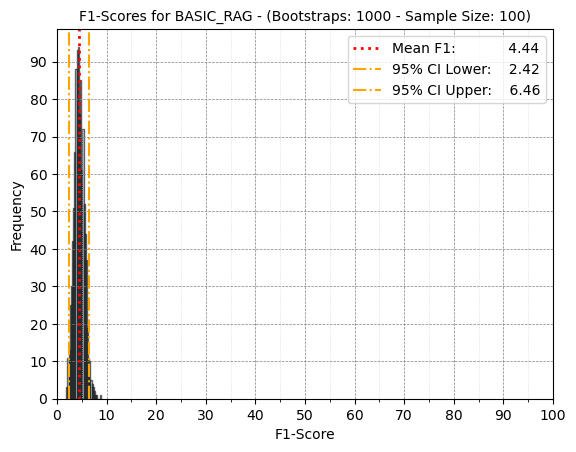

In [30]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG", 1, context_needed=True)


##### Calculate results for BASIC_RAG_DONT_LIE

============= Creating results folder for BASIC_RAG_DONT_LIE =============
============= Calculating scores for BASIC_RAG_DONT_LIE =============
SAMPLE_SIZE: 100
current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer, keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
all_preds: {'57094b4f9928a814004714fa': 'EasyJet Holidays', '5a668d25f038b70

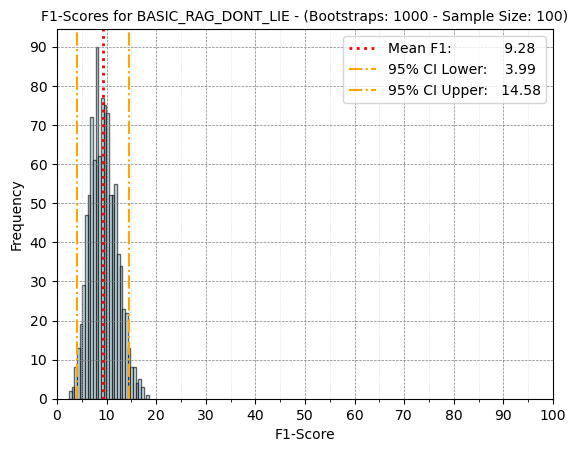

In [31]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG_DONT_LIE", 2, context_needed=True)

##### Caclulation for BASIC_RAG_SUPPRESS_ANSWSERS

In [ ]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG_SUPPRESS_ANSWERS", 2, context_needed=True, suppress_answers=True)

##### Calculation for BASIC_RAG_HYDE_ANSWERS

In [ ]:
conduct_experiment(qas_for_hyde_bootstrapping, "BASIC_RAG_HYDE", 1, context_needed=True, suppress_answers=False    )

In [ ]:
conduct_experiment(qas_for_hyde_bootstrapping, "FULL_RAG", 2, context_needed=True, suppress_answers=False)